In [2]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# Import regression and statmodels libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# pandas dataframe configurations
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
DATA_PATH = '../input/store-sales-time-series-forecasting/'

# Read the data
df_store_sales = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'),
                             usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                             dtype = {
                                    'store_nbr': 'category',
                                    'family': 'category',
                                    'sales': 'float32',
                                    'onpromotion': 'uint32',
                                },
                                parse_dates=['date'],
                                infer_datetime_format=True)

df_store_sales['date'] = df_store_sales.date.dt.to_period('D')
df_store_sales = df_store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()


df_holiday_events = pd.read_csv(os.path.join(DATA_PATH, 'holidays_events.csv'),
                                dtype={
                                    'type': 'category',
                                    'locale': 'category',
                                    'locale_name': 'category',
                                    'description': 'category',
                                    'transferred': 'bool',
                                },
                                parse_dates=['date'],
                                infer_datetime_format=True)
df_holiday_events = df_holiday_events.set_index('date').to_period('D')

df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'),
                    dtype={
                        'store_nbr': 'category',
                        'family': 'category',
                        'onpromotion': 'uint32',
                    },
                    parse_dates=['date'],
                    infer_datetime_format=True )
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

df_stores = pd.read_csv(os.path.join(DATA_PATH, 'stores.csv'))
df_transactions = pd.read_csv(os.path.join(DATA_PATH, 'transactions.csv')).sort_values(['store_nbr', 'date'])
df_oil = pd.read_csv(os.path.join(DATA_PATH, 'oil.csv'))
df_submission_sample = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

### Average sales 

In [4]:
average_sales = df_store_sales.groupby('date').mean().sales

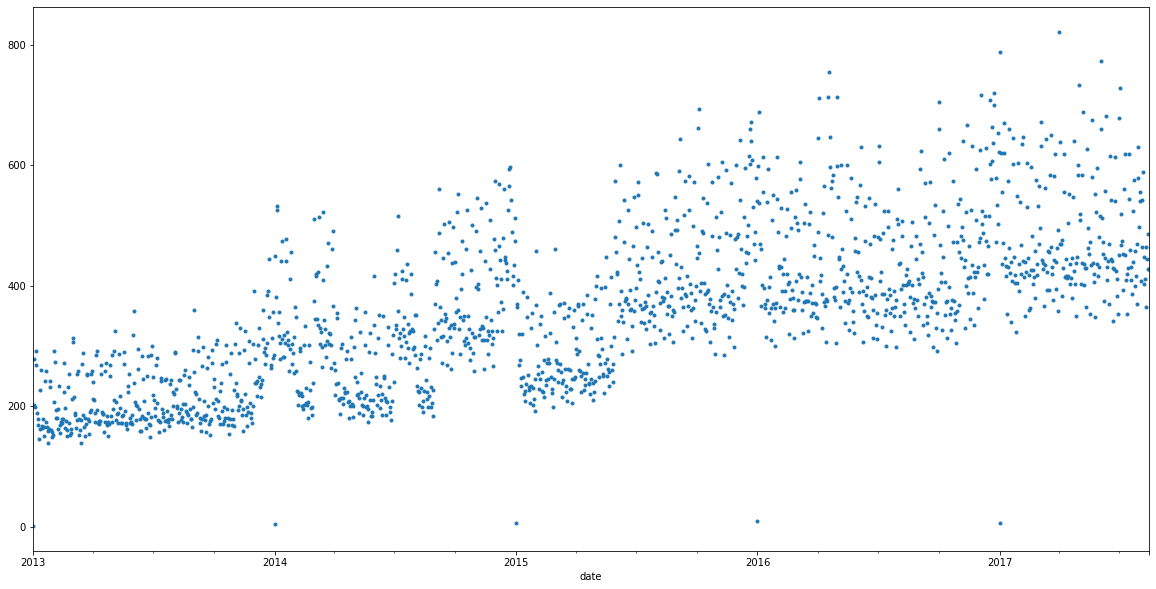

In [5]:
average_sales.plot(style='.', figsize=(20,10));

In [6]:
average_sales_2017 = (
    df_store_sales
    .groupby('date')
    .mean().sales.squeeze().loc['2017'])

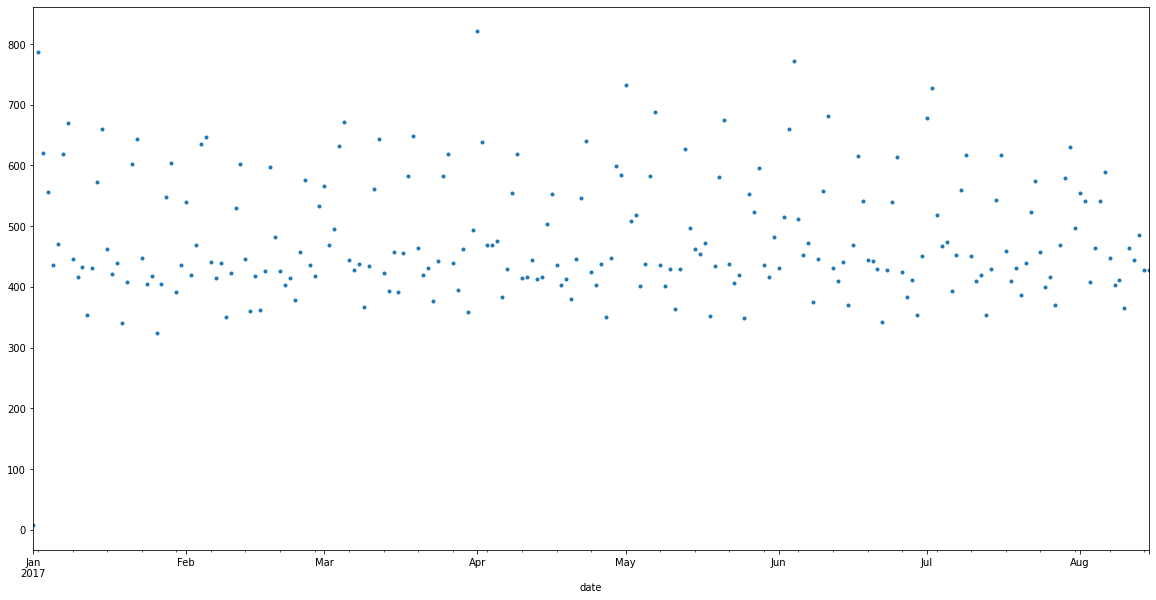

In [7]:
average_sales_2017.plot(style='.', figsize=(20,10));

In [8]:
y = average_sales_2017.copy()

In [9]:
fourier_terms = CalendarFourier(freq='M', order = 4)

In [10]:
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order = 1,
    seasonal = True,
    additional_terms=[fourier_terms],
    drop = True,
)

X = dp.in_sample()

In [11]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000
2017-01-02,1.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2013,0.9795,0.3944,0.9190,0.5713,0.8208,0.7248,0.6890
2017-01-03,1.0000,3.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.3944,0.9190,0.7248,0.6890,0.9378,0.3473,0.9987,-0.0506
2017-01-04,1.0000,4.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.5713,0.8208,0.9378,0.3473,0.9681,-0.2507,0.6514,-0.7588
2017-01-05,1.0000,5.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7248,0.6890,0.9987,-0.0506,0.6514,-0.7588,-0.1012,-0.9949


In [12]:
model_1 = LinearRegression().fit(X, y)
y1_pred = pd.Series(model_1.predict(X), index=X.index, 
                    name='4 Fourier Terms')

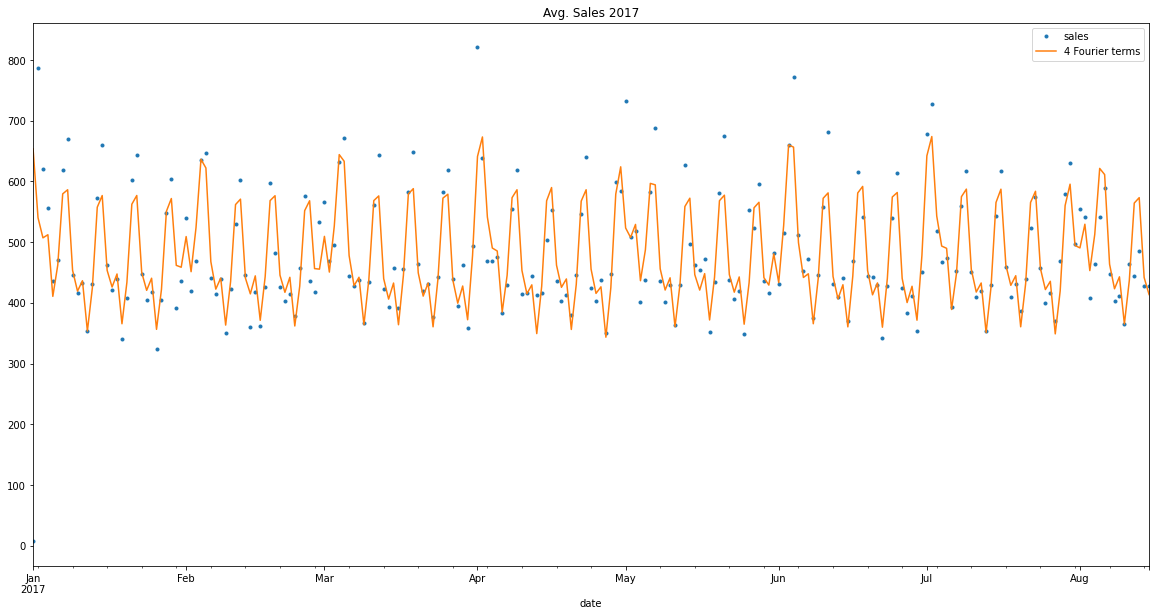

In [13]:
ax=y.plot(style='.', figsize=(20,10), title="Avg. Sales 2017")
ax=y1_pred.plot(ax=ax, label='4 Fourier terms')
ax.legend();

In [14]:
X_forecast = dp.out_of_sample(steps=30)
y_forecast = pd.Series(model_1.predict(X_forecast),
                      index=X_forecast.index)

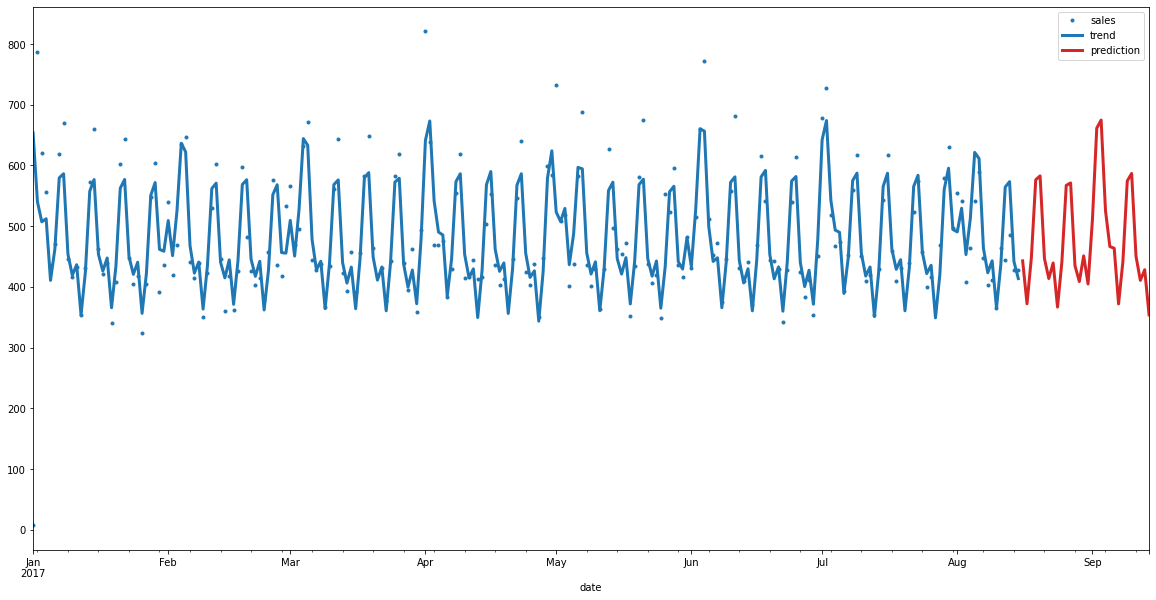

In [15]:
ax=average_sales_2017.plot(style='.', figsize=(20,10))
ax=y1_pred.plot(ax=ax, linewidth=3, label='trend', color='C0')
ax=y_forecast.plot(ax=ax, linewidth=3, label='prediction', 
                   color='C3')
ax.legend();

In [31]:
df_holiday_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [37]:
len(df_holiday_events.query("locale in ['National', 'Regional']").loc['2017':'2017-08-15', ['description']])

14

In [39]:
holidays = (df_holiday_events.query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories()))

In [41]:
(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


In [19]:
y_d = y - y1_pred

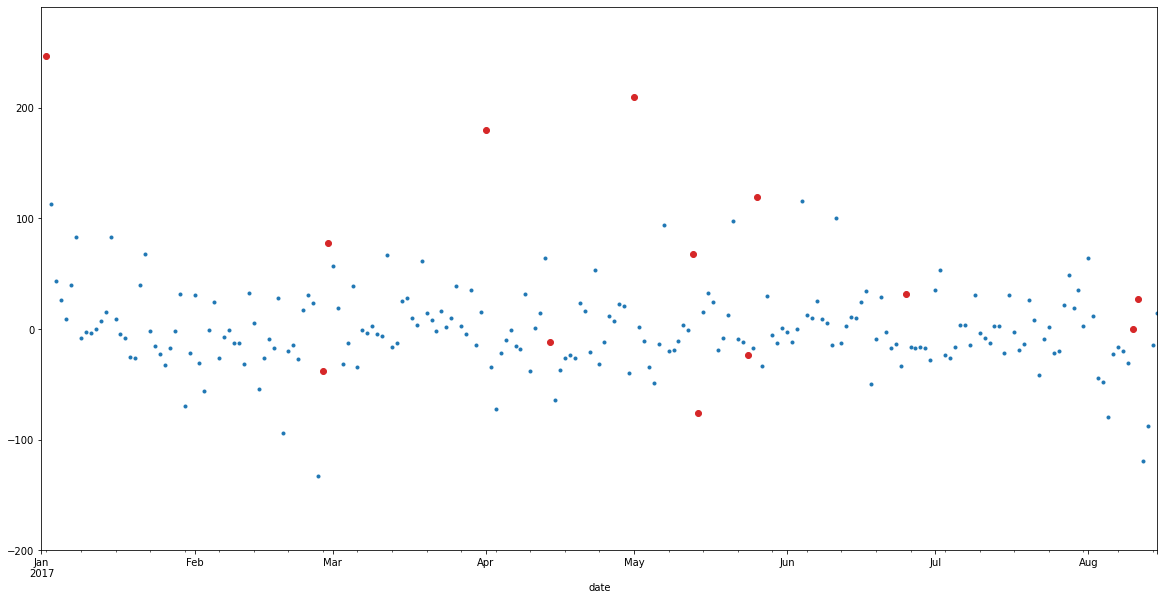

In [20]:
ax=y_d.plot(style='.', figsize=(20,10))
plt.plot_date(holidays.index, y_d[holidays.index], color='C3')
ax.set_ylim(bottom=-200);

In [21]:
X_holiday = pd.get_dummies(holidays)

In [22]:
X_holiday.head()

,description_Batalla de Pichincha,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,
2017-01-01,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-02-27,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-02-28,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-04-01,0,0,0,0,0,0,0,1,0,0,0,0,0


In [23]:
X2 = X.join(X_holiday, on='date').fillna(0.)

In [24]:
X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",description_Batalla de Pichincha,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-01-02,1.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2013,0.9795,0.3944,0.9190,0.5713,0.8208,0.7248,0.6890,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2017-01-03,1.0000,3.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.3944,0.9190,0.7248,0.6890,0.9378,0.3473,0.9987,-0.0506,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-01-04,1.0000,4.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.5713,0.8208,0.9378,0.3473,0.9681,-0.2507,0.6514,-0.7588,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-01-05,1.0000,5.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7248,0.6890,0.9987,-0.0506,0.6514,-0.7588,-0.1012,-0.9949,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [25]:
model_2 = LinearRegression().fit(X2, y)
y2_pred = pd.Series(model_2.predict(X2), index=X2.index,
                   name='Fourier + holidays')

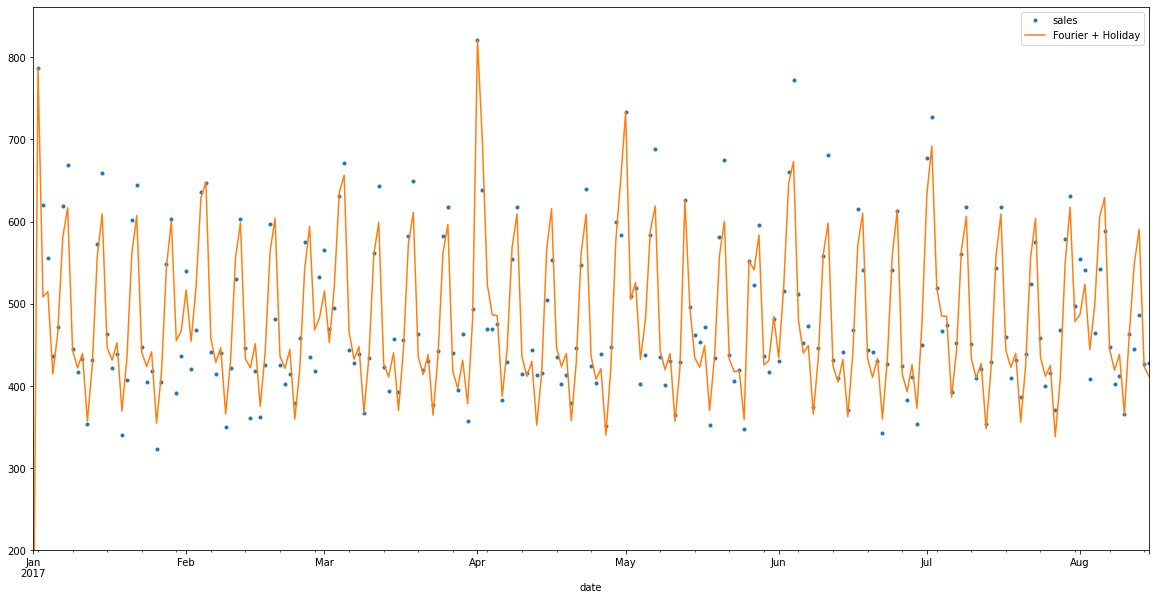

In [26]:
ax1 = y.plot(style='.', figsize=(20,10))
ax1 = y2_pred.plot(ax=ax1, label='Fourier + Holiday')
ax1.set_ylim(bottom=200)
ax1.legend();

In [28]:
holidays2 = (df_holiday_events.query("locale in ['National', 'Regional']")
            .loc['2017-08-15':, ['description']]
            .assign(description=lambda x: x.description.cat.remove_unused_categories()))

In [29]:
holidays2

,description
date,
2017-10-09,Independencia de Guayaquil
2017-11-02,Dia de Difuntos
2017-11-03,Independencia de Cuenca
2017-11-06,Provincializacion de Santo Domingo
2017-11-07,Provincializacion Santa Elena
2017-12-21,Navidad-4
2017-12-22,Navidad-3
2017-12-23,Navidad-2
2017-12-24,Navidad-1


In [42]:
df_store_sales.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01 0.0000            0
                     2013-01-02 2.0000            0
                     2013-01-03 3.0000            0
                     2013-01-04 3.0000            0
                     2013-01-05 5.0000            0

In [43]:
y=df_store_sales.unstack(['store_nbr','family']).loc['2017']

In [44]:
y

sales                                                 \
store_nbr           1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES  BOOKS BREAD/BAKERY   
date                                                                   
2017-01-01     0.0000    0.0000 0.0000    0.0000 0.0000       0.0000   
2017-01-02     5.0000    0.0000 0.0000 1434.0000 0.0000     166.8190   
2017-01-03     4.0000    0.0000 4.0000 3081.0000 2.0000     519.3480   
2017-01-04     1.0000    0.0000 4.0000 3039.0000 2.0000     543.2510   
2017-01-05     2.0000    0.0000 3.0000 2617.0000 0.0000     533.4800   
...               ...       ...    ...       ...    ...          ...   
2017-08-11     1.0000    0.0000 1.0000 1006.0000 0.0000     145.6070   
2017-08-12     6.0000    0.0000 3.0000 1659.0000 0.0000     243.2200   
2017-08-13     1.0000    0.0000 1.0000  803.0000 0.0000     136.6790   
2017-08-14     1.0000    0.0000 6.0000 2201.0000 0.0000     346.0380   
2017-08-15     4.0000    0.0000 4.0000 1942.0000 0.0000     329.5410   

                                                                           \
store_nbr                                                                   
family     CELEBRATION  CLEANING     DAIRY     DELI     EGGS FROZEN FOODS   
date                                                                        
2017-01-01      0.0000    0.0000    0.0000   0.0000   0.0000       0.0000   
2017-01-02      0.0000  332.0000  376.0000  44.9800  76.0000      72.1500   
2017-01-03     15.0000  952.0000 1045.0000 209.3000 202.0000     124.1760   
2017-01-04     17.0000 1055.0000 1029.0000 135.9440 197.0000     115.0000   
2017-01-05     40.0000  918.0000  853.0000 137.0060 159.0000     157.5140   
...                ...       ...       ...      ...      ...          ...   
2017-08-11      4.0000  341.0000  343.0000  64.3020  86.0000      61.0000   
2017-08-12      3.0000  351.0000  526.0000  99.4880 113.0000     107.7940   
2017-08-13      1.0000  169.0000  266.0000  47.7700  60.0000      50.0000   
2017-08-14      4.0000  571.0000  699.0000 154.5780 170.0000     110.0000   
2017-08-15     21.0000  703.0000  602.0000 116.4020 131.0000      89.0000   

                                                             \
store_nbr                                                     
family     GROCERY I GROCERY II HARDWARE HOME AND KITCHEN I   
date                                                          
2017-01-01    0.0000     0.0000   0.0000             0.0000   
2017-01-02 1218.0000     8.0000   0.0000             4.0000   
2017-01-03 3507.0000    15.0000   3.0000            36.0000   
2017-01-04 3665.0000    27.0000   3.0000            36.0000   
2017-01-05 3085.0000    35.0000   3.0000            30.0000   
...              ...        ...      ...                ...   
2017-08-11 1270.0000     9.0000   1.0000            27.0000   
2017-08-12 1630.0000    19.0000   0.0000            17.0000   
2017-08-13  952.0000     6.0000   1.0000            13.0000   
2017-08-14 2407.0000    20.0000   0.0000            50.0000   
2017-08-15 2508.0000    13.0000   3.0000            30.0000   

                                                                     \
store_nbr                                                             
family     HOME AND KITCHEN II HOME APPLIANCES HOME CARE LADIESWEAR   
date                                                                  
2017-01-01              0.0000          0.0000    0.0000     0.0000   
2017-01-02              2.0000          0.0000  108.0000     4.0000   
2017-01-03             40.0000          0.0000  294.0000    19.0000   
2017-01-04             31.0000          0.0000  274.0000    18.0000   
2017-01-05             19.0000          0.0000  242.0000    11.0000   
...                        ...             ...       ...        ...   
2017-08-11             14.0000          0.0000   74.0000     3.0000   
2017-08-12             31.0000          0.0000  116.

In [45]:
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

In [46]:
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

In [47]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [48]:
y_pred = pd.DataFrame(model.predict(X), index=X.index, 
                      columns=y.columns)

In [50]:
X_test = dp.out_of_sample(steps=16)

In [51]:
X_test.index.name='date'
X_test['NewYear']=(X_test.index.dayofyear == 1)

In [52]:
y_submit = model.predict(X_test)

In [53]:
y_submit = pd.DataFrame(y_submit, index=X_test.index,
                       columns=y.columns)

In [54]:
y_submit = y_submit.stack(['store_nbr', 'family'])

In [55]:
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])

In [56]:
y_submit.to_csv('submission.csv', index=False)